## STATS 551 Final Project
### Uniqname: chenfeiw
### UMID: 73271527

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from cmdstanpy import CmdStanModel

In [26]:
file_path = 'IMDB_movie_reviews_details.csv'
data = pd.read_csv(file_path)

In [27]:
data.head()

,Unnamed: 0,name,year,runtime,genre,rating,metascore,timeline,votes,gross
0,0,The Shawshank Redemption,1994,142,Drama,9.3,80.0,Two imprisoned men bond over a number of years...,"2,394,059",$28.34M
1,1,The Godfather,1972,175,"Crime, Drama",9.2,100.0,An organized crime dynasty's aging patriarch t...,"1,658,439",$134.97M
2,2,Soorarai Pottru,2020,153,Drama,9.1,NaN,"Nedumaaran Rajangam ""Maara"" sets out to make t...","78,266",NaN
3,3,The Dark Knight,2008,152,"Action, Crime, Drama",9.0,84.0,When the menace known as the Joker wreaks havo...,"2,355,907",$534.86M
4,4,The Godfather: Part II,1974,202,"Crime, Drama",9.0,90.0,The early life and career of Vito Corleone in ...,"1,152,912",$57.30M


### Data Cleaning

In [28]:
data_cleaned = data.drop(columns=["Unnamed: 0", "timeline"])

In [29]:
data_cleaned['gross'] = data_cleaned['gross'].\
    str.replace('[\$,M]', '', regex=True).astype(float)
data_cleaned['metascore'] = data_cleaned['metascore'].\
    fillna(data_cleaned['metascore'].mean())
data_cleaned = data_cleaned.dropna(subset=['gross'])
data_cleaned['genre'] = data_cleaned['genre'].\
    fillna('Unknown')

In [30]:
data_cleaned = data_cleaned.drop_duplicates()

In [31]:
data_cleaned['year'] = data_cleaned['year'].\
    str.extract('(\d{4})').astype(float)
data_cleaned = data_cleaned.dropna(subset=['year'])
data_cleaned['year'] = data_cleaned['year'].astype(int)

In [32]:
data_expanded = data_cleaned.copy()
data_expanded = data_expanded.\
    assign(genre=data_cleaned['genre'].str.split(',')).explode('genre')
data_expanded['genre'] = data_expanded['genre'].str.strip()

In [33]:
data_expanded = data_expanded.drop_duplicates(subset=['name'], keep='first')

In [34]:
year_genre = data_expanded.groupby(['year', 'genre']).agg({
    'rating': 'mean',
    'votes': 'sum',
    'gross': 'sum'
}).reset_index()

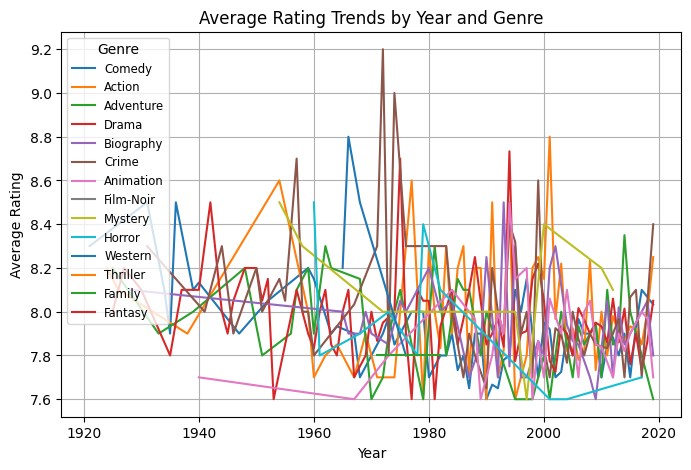

In [35]:
plt.figure(figsize=(8, 5))
for genre in year_genre['genre'].unique():
    subset = year_genre[year_genre['genre'] == genre]
    plt.plot(subset['year'], subset['rating'], label=genre)

plt.title('Average Rating Trends by Year and Genre')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.legend(loc='best', fontsize='small', title='Genre')
plt.grid(True)
plt.show()

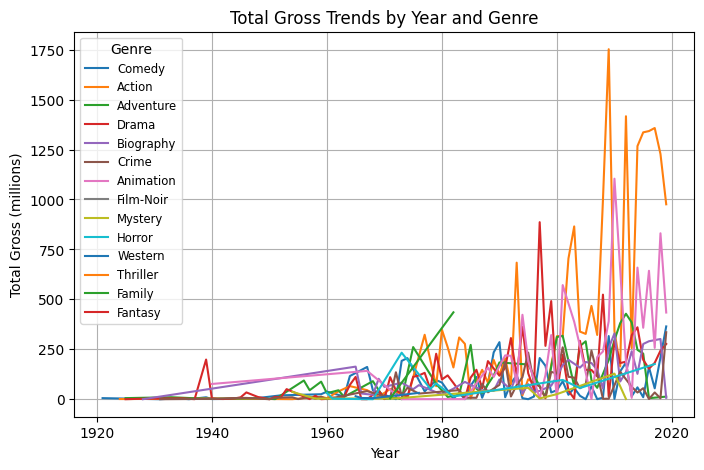

In [36]:
plt.figure(figsize=(8, 5))
for genre in year_genre['genre'].unique():
    subset = year_genre[year_genre['genre'] == genre]
    plt.plot(subset['year'], subset['gross'], label=genre)

plt.title('Total Gross Trends by Year and Genre')
plt.xlabel('Year')
plt.ylabel('Total Gross (millions)')
plt.legend(loc='best', fontsize='small', title='Genre')
plt.grid(True)
plt.show()

As can be seen from the figure, the overall box office \
of movies shows an upward trend as the year increases.

In [44]:
data_simple = data_expanded[['year', 'genre', 'rating', 'gross']]

In [46]:
data_simple.to_csv("movie_analyse.csv", index=False)

## Bayesian Inference

### About Rating

In [50]:
from sklearn.preprocessing import StandardScaler

In [58]:
scaler = StandardScaler()
data_simple['year_scaled'] = scaler.fit_transform(data_simple[['year']])
genre_codes = pd.Categorical(data_simple['genre']).codes + 1

stan_data = {
    'N': len(data_simple),
    'J': 14,
    'K': 1,
    'x': data_simple['year_scaled'].values,
    'y': data_simple['rating'].values,
    'genre': pd.Categorical(data_simple['genre']).codes + 1
}

C:\Users\84207\AppData\Local\Temp\ipykernel_74180\2225896691.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_simple['year_scaled'] = scaler.fit_transform(data_simple[['year']])


#### simple bayesian model

In [47]:
stan_model_code = """
data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  alpha ~ normal(0, 1);
  beta ~ normal(0, 1);
  sigma ~ normal(0, 1);

  y ~ normal(alpha + beta * x, sigma);
}
"""

In [48]:
stan_model_file = 'movie_rating_model.stan'
with open(stan_model_file, 'w') as file:
    file.write(stan_model_code)

In [49]:
stan_model = CmdStanModel(stan_file="movie_rating_model.stan")

17:11:06 - cmdstanpy - INFO - compiling stan file C:\Users\84207\Desktop\SI618\si618fa23-student-main\inclass\movie_rating_model.stan to exe file C:\Users\84207\Desktop\SI618\si618fa23-student-main\inclass\movie_rating_model.exe
17:12:12 - cmdstanpy - INFO - compiled model executable: C:\Users\84207\Desktop\SI618\si618fa23-student-main\inclass\movie_rating_model.exe


In [55]:
stan_data = {
    'N': len(data_simple),
    'x': data_simple['year_scaled'].values,
    'y': data_simple['rating'].values
}

In [56]:
fit = stan_model.sample(data=stan_data, chains=4, \
                        iter_sampling=1000, iter_warmup=500)

17:16:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:16:45 - cmdstanpy - INFO - CmdStan done processing.
17:16:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'movie_rating_model.stan', line 19, column 2 to column 38)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'movie_rating_model.stan', line 19, column 2 to column 38)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'movie_rating_model.stan', line 19, column 2 to column 38)
Consider re-running with show_console=True if the above output is unclear!


In [57]:
print(fit.summary())

             Mean      MCSE    StdDev          5%         50%         95%  \
lp__   613.945000  0.025513  1.198510  611.572000  614.259000  615.236000   
alpha    7.948390  0.000140  0.009342    7.933350    7.948260    7.963860   
beta    -0.050258  0.000141  0.009852   -0.066835   -0.050332   -0.034069   
sigma    0.278008  0.000122  0.006810    0.266825    0.277926    0.289453   

         N_Eff   N_Eff/s     R_hat  
lp__   2206.81   7689.22  1.001750  
alpha  4478.91  15606.00  1.000530  
beta   4850.38  16900.30  0.999851  
sigma  3116.11  10857.50  0.999556  


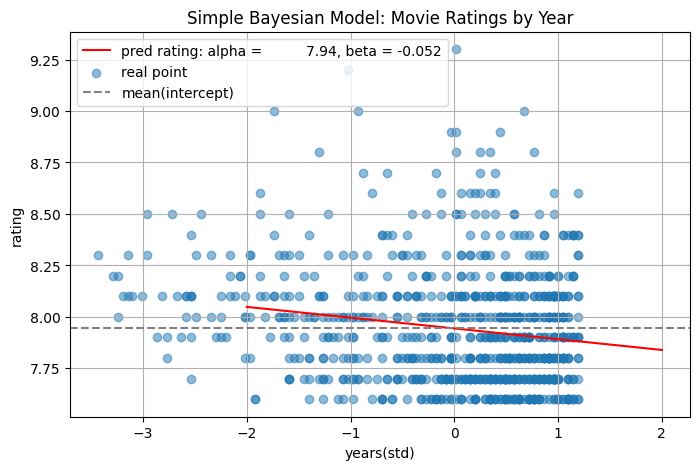

In [106]:
alpha_mean = 7.9439
beta_mean = -0.052258
x = np.linspace(-2, 2, 100)
y_pred = alpha_mean + beta_mean * x

plt.figure(figsize=(8, 5))
plt.plot(x, y_pred, label=f'pred rating: alpha = \
         {alpha_mean:.2f}, beta = {beta_mean:.3f}', color='red')
plt.scatter(data_simple['year_scaled'], data_simple['rating'], \
            alpha=0.5, label='real point')
plt.axhline(alpha_mean, linestyle='--', color='gray', \
            label='mean(intercept)')
plt.title('Simple Bayesian Model: Movie Ratings by Year')
plt.xlabel('years(std)')
plt.ylabel('rating')
plt.legend()
plt.grid()
plt.show()

As the years go by, the ratings of movies show a slight downward trend.

#### Bayesian Hierarchical Model

In [63]:
stan_model_hier = """
data {
  int<lower=1> N;
  int<lower=1> J;
  array[N] int<lower=1, upper=J> genre;
  vector[N] x;
  vector[N] y;
}
parameters {
  vector[J] alpha;
  vector[J] beta;
  real mu_alpha;
  real mu_beta;
  real<lower=0> sigma_alpha;
  real<lower=0> sigma_beta;
  real<lower=0> sigma;
}
model {
  mu_alpha ~ normal(0, 1);
  mu_beta ~ normal(0, 1);
  sigma_alpha ~ normal(0, 1);
  sigma_beta ~ normal(0, 1);
  sigma ~ normal(0, 1);

  alpha ~ normal(mu_alpha, sigma_alpha);
  beta ~ normal(mu_beta, sigma_beta);

  for (n in 1:N)
    y[n] ~ normal(alpha[genre[n]] + beta[genre[n]] * x[n], sigma);
}
"""

In [64]:
stan_file_hier = "genre_rating_hierarchical.stan"
with open(stan_file_hier, "w") as f:
    f.write(stan_model_hier)

In [65]:
stan_data = {
    'N': len(data_simple),
    'J': len(set(genre_codes)),
    'genre': genre_codes,
    'x': data_simple['year_scaled'].values,
    'y': data_simple['rating'].values
}

In [66]:
stan_model = CmdStanModel(stan_file="genre_rating_hierarchical.stan")

17:35:27 - cmdstanpy - INFO - compiling stan file C:\Users\84207\Desktop\SI618\si618fa23-student-main\inclass\genre_rating_hierarchical.stan to exe file C:\Users\84207\Desktop\SI618\si618fa23-student-main\inclass\genre_rating_hierarchical.exe
17:35:43 - cmdstanpy - INFO - compiled model executable: C:\Users\84207\Desktop\SI618\si618fa23-student-main\inclass\genre_rating_hierarchical.exe


In [67]:
fit = stan_model.sample(data=stan_data, chains=4, \
                        iter_sampling=1000, iter_warmup=500)

17:35:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:35:47 - cmdstanpy - INFO - CmdStan done processing.
17:35:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'genre_rating_hierarchical.stan', line 26, column 2 to column 37)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'genre_rating_hierarchical.stan', line 29, column 4 to column 66)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'genre_rating_hierarchical.stan', line 25, column 2 to column 40)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'genre_rating_hierarchical.stan', line 26, column 2 to column 37)
Consider re-running with show_console=True if the above output is unclear!
17:35:47 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 13 divergent transitions (1.3%)
	Chain 2 had 45 divergent transitions (4.5%)
	Chain 3 had 11 divergent transitions (1.1%)
	Chain 4 had 218 divergent transitions (21

In [77]:
category_mapping = pd.Categorical(data_simple['genre']).categories
for code, category in enumerate(category_mapping):
    print(f"{code+1} -> {category}")

1 -> Action
2 -> Adventure
3 -> Animation
4 -> Biography
5 -> Comedy
6 -> Crime
7 -> Drama
8 -> Family
9 -> Fantasy
10 -> Film-Noir
11 -> Horror
12 -> Mystery
13 -> Thriller
14 -> Western


In [68]:
print(fit.summary())

                   Mean      MCSE     StdDev          5%         50%  \
lp__         702.215000  1.801650  12.290900  683.787000  700.828000   
alpha[1]       7.950140  0.000771   0.019822    7.919230    7.949190   
alpha[2]       7.938030  0.001231   0.026360    7.895360    7.938680   
alpha[3]       7.939650  0.003211   0.027627    7.889420    7.941300   
alpha[4]       7.949230  0.000595   0.022483    7.912790    7.949500   
alpha[5]       7.915060  0.001273   0.023884    7.873270    7.917470   
alpha[6]       7.980830  0.000914   0.026074    7.942180    7.977590   
alpha[7]       7.947810  0.001955   0.016884    7.917690    7.948170   
alpha[8]       7.938550  0.001086   0.045458    7.863800    7.940190   
alpha[9]       7.940250  0.001108   0.043701    7.863660    7.943180   
alpha[10]      7.946360  0.001340   0.044788    7.880810    7.945100   
alpha[11]      7.935620  0.001662   0.038274    7.870060    7.938370   
alpha[12]      7.966240  0.003956   0.044139    7.906510    7.96

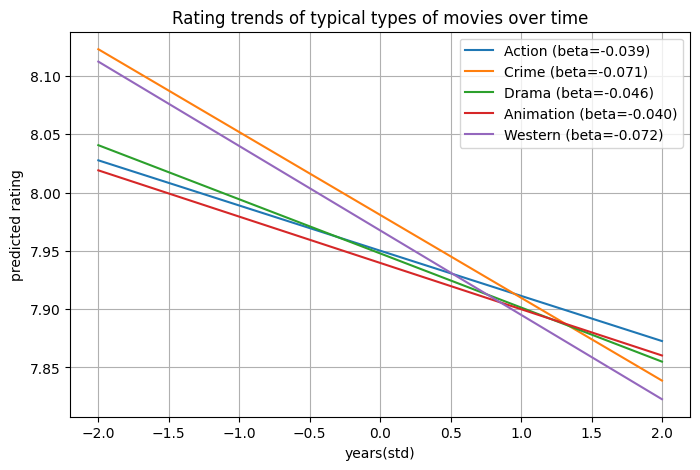

In [105]:
selected_genres = {"Action": 1, "Crime": 6, "Drama": \
                   7, "Animation": 3, "Western": 14}
selected_params = {
    genre: {"alpha": fit.stan_variable('alpha')[:, index - 1].mean(),
            "beta": fit.stan_variable('beta')[:, index - 1].mean()}
    for genre, index in selected_genres.items()
}

plt.figure(figsize=(8, 5))
x = np.linspace(-2, 2, 100)
for genre, params in selected_params.items():
    y_pred = params['alpha'] + params['beta'] * x
    plt.plot(x, y_pred, label=f"{genre} (beta={params['beta']:.3f})")
plt.title("Rating trends of typical types of movies over time")
plt.xlabel("years(std)")
plt.ylabel("predicted rating")
plt.legend()
plt.grid()
plt.show()

The downward trend in the ratings of westerns and crime films is more obvious, \
which may be related to the fact that the "golden years" of these two types of movies have passed.

### About Gross

#### simple bayesian model

In [79]:
data_simple['year_scaled'] = scaler.fit_transform(data_simple[['year']])

C:\Users\84207\AppData\Local\Temp\ipykernel_74180\311116061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_simple['year_scaled'] = scaler.fit_transform(data_simple[['year']])


In [80]:
stan_data_gross = {
    'N': len(data_simple),
    'x': data_simple['year_scaled'].values,
    'y': data_simple['gross'].values
}

In [81]:
simple_gross_model_code = """
data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  alpha ~ normal(0, 10);
  beta ~ normal(0, 10);
  sigma ~ normal(0, 10);

  y ~ normal(alpha + beta * x, sigma);
}
"""

In [82]:
simple_gross_model_file = "simple_gross_model.stan"
with open(simple_gross_model_file, "w") as f:
    f.write(simple_gross_model_code)

In [83]:
simple_gross_model_file

'simple_gross_model.stan'

In [84]:
simple_gross_model = CmdStanModel(stan_file='simple_gross_model.stan')

18:17:26 - cmdstanpy - INFO - compiling stan file C:\Users\84207\Desktop\SI618\si618fa23-student-main\inclass\simple_gross_model.stan to exe file C:\Users\84207\Desktop\SI618\si618fa23-student-main\inclass\simple_gross_model.exe
18:17:43 - cmdstanpy - INFO - compiled model executable: C:\Users\84207\Desktop\SI618\si618fa23-student-main\inclass\simple_gross_model.exe


In [85]:
fit_gross = simple_gross_model.sample(data=stan_data_gross, chains=4, \
                                      iter_sampling=1000, iter_warmup=500)

18:17:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:44 - cmdstanpy - INFO - CmdStan done processing.


In [86]:
print(fit_gross.summary())

            Mean      MCSE   StdDev         5%        50%        95%    N_Eff  \
lp__  -4355.7200  0.026192  1.19713 -4358.0000 -4355.4400 -4354.4200  2089.06   
alpha    60.7234  0.054003  3.28721    55.2663    60.7039    66.0684  3705.27   
beta     23.2628  0.051818  3.24083    17.9511    23.2288    28.6531  3911.64   
sigma   101.2430  0.035294  2.24686    97.5857   101.2420   104.9990  4052.73   

        N_Eff/s     R_hat  
lp__    7487.67  1.001440  
alpha  13280.50  1.000290  
beta   14020.20  1.000260  
sigma  14525.90  0.999667  


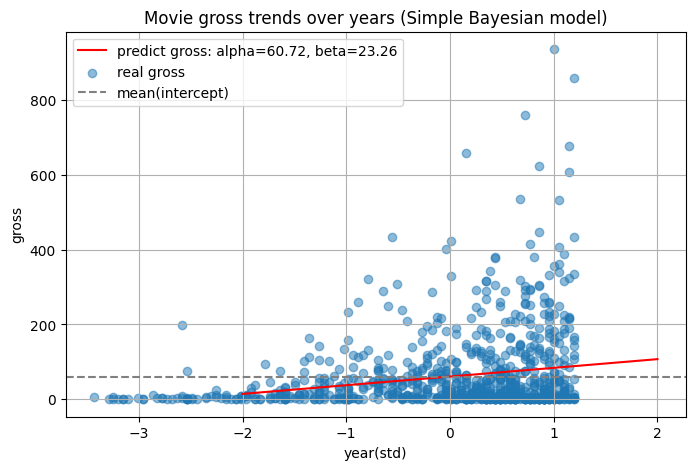

In [104]:
alpha_mean = 60.7234
beta_mean = 23.2628

x_years = np.linspace(-2, 2, 100)
y_pred = alpha_mean + beta_mean * x_years

plt.figure(figsize=(8, 5))
plt.plot(x_years, y_pred, color='red', label=f'predict gross: \
         alpha={alpha_mean:.2f}, beta={beta_mean:.2f}')
plt.scatter(data_simple['year_scaled'], data_simple['gross'], \
            alpha=0.5, label='real gross')
plt.title("Movie gross trends over years (Simple Bayesian model)")
plt.xlabel("year(std)")
plt.ylabel("gross")
plt.axhline(alpha_mean, linestyle='--', color='gray', \
            label='mean(intercept)')
plt.legend()
plt.grid()
plt.show()

#### Bayesian Hierarchical Model

In [93]:
stan_gross_model_hier = """
data {
  int<lower=1> N;
  int<lower=1> J;
  array[N] int<lower=1, upper=J> genre;
  vector[N] x;
  vector[N] y;
}
parameters {
  vector[J] alpha;
  vector[J] beta;
  real mu_alpha;
  real mu_beta;
  real<lower=0> sigma_alpha;
  real<lower=0> sigma_beta;
  real<lower=0> sigma;
}
model {
  mu_alpha ~ normal(0, 10);
  mu_beta ~ normal(0, 10);
  sigma_alpha ~ normal(0, 10);
  sigma_beta ~ normal(0, 10);
  sigma ~ normal(0, 10);

  alpha ~ normal(mu_alpha, sigma_alpha);
  beta ~ normal(mu_beta, sigma_beta);

  for (n in 1:N)
    y[n] ~ normal(alpha[genre[n]] + beta[genre[n]] * x[n], sigma);
}
"""

In [94]:
stan_gross_file_hier = "genre_gross_hierarchical.stan"
with open(stan_gross_file_hier, "w") as f:
    f.write(stan_gross_model_hier)

In [95]:
stan_data_gross_hier = {
    'N': len(data_simple),
    'J': len(set(genre_codes)),
    'genre': genre_codes,
    'x': data_simple['year_scaled'].values,
    'y': data_simple['gross'].values
}

In [96]:
stan_gross_model_hier

'\ndata {\n  int<lower=1> N;\n  int<lower=1> J;\n  array[N] int<lower=1, upper=J> genre;\n  vector[N] x;\n  vector[N] y;\n}\nparameters {\n  vector[J] alpha;\n  vector[J] beta;\n  real mu_alpha;\n  real mu_beta;\n  real<lower=0> sigma_alpha;\n  real<lower=0> sigma_beta;\n  real<lower=0> sigma;\n}\nmodel {\n  mu_alpha ~ normal(0, 10);\n  mu_beta ~ normal(0, 10);\n  sigma_alpha ~ normal(0, 10);\n  sigma_beta ~ normal(0, 10);\n  sigma ~ normal(0, 10);\n\n  alpha ~ normal(mu_alpha, sigma_alpha);\n  beta ~ normal(mu_beta, sigma_beta);\n\n  for (n in 1:N)\n    y[n] ~ normal(alpha[genre[n]] + beta[genre[n]] * x[n], sigma);\n}\n'

In [97]:
hier_gross_model = CmdStanModel(stan_file='genre_gross_hierarchical.stan')

18:34:33 - cmdstanpy - INFO - compiling stan file C:\Users\84207\Desktop\SI618\si618fa23-student-main\inclass\genre_gross_hierarchical.stan to exe file C:\Users\84207\Desktop\SI618\si618fa23-student-main\inclass\genre_gross_hierarchical.exe
18:34:49 - cmdstanpy - INFO - compiled model executable: C:\Users\84207\Desktop\SI618\si618fa23-student-main\inclass\genre_gross_hierarchical.exe


In [98]:
fit_gross_hier = hier_gross_model.sample(data=stan_data_gross_hier, chains=4, \
                                      iter_sampling=1000, iter_warmup=500)

18:34:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:34:54 - cmdstanpy - INFO - CmdStan done processing.


In [99]:
print(fit_gross_hier.summary())

                    Mean      MCSE     StdDev          5%         50%  \
lp__        -4368.090000  0.123481   4.643790 -4376.27000 -4367.76000   
alpha[1]      124.996000  0.107890   8.092550   111.48100   124.97200   
alpha[2]       89.695200  0.151453  11.716800    70.47670    89.55970   
alpha[3]      102.618000  0.177070  12.418400    82.04590   102.41100   
alpha[4]       54.883200  0.126720  10.232600    38.07940    54.81000   
alpha[5]       33.076800  0.101047   8.090600    20.02320    33.12390   
alpha[6]       35.593700  0.121355   9.129320    20.57150    35.55600   
alpha[7]       38.699100  0.078188   5.855980    29.18860    38.61340   
alpha[8]       71.256700  0.440807  31.308500    19.86150    71.04570   
alpha[9]       28.005600  0.459042  32.568100   -26.47110    28.02090   
alpha[10]      29.977300  0.437572  32.603100   -24.68030    30.05380   
alpha[11]      57.765100  0.286602  22.130900    21.82760    57.80400   
alpha[12]      33.781500  0.342929  24.181900    -6

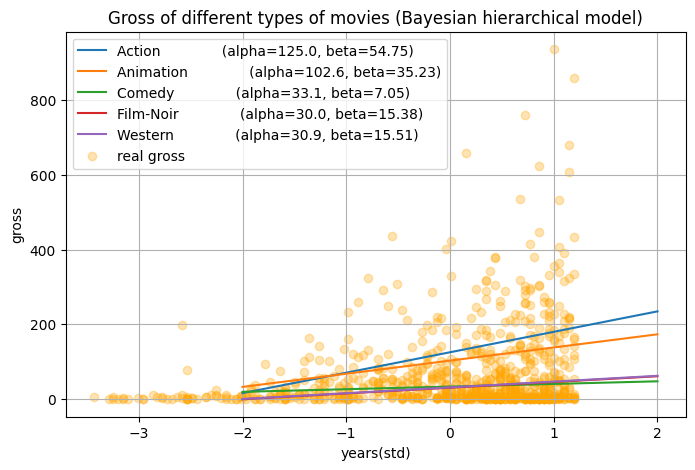

In [103]:
selected_types = {1: "Action", 3: "Animation", 5: "Comedy", \
                  10: "Film-Noir", 14: "Western"}
selected_params = {
    genre: {
        "alpha": fit_gross_hier.stan_variable('alpha')[:, index - 1].mean(),
        "beta": fit_gross_hier.stan_variable('beta')[:, index - 1].mean()
    }
    for index, genre in selected_types.items()
}

plt.figure(figsize=(8, 5))
x_years = np.linspace(-2, 2, 100)
for genre, params in selected_params.items():
    y_pred = params["alpha"] + params["beta"] * x_years
    plt.plot(x_years, y_pred, label=f"{genre} \
             (alpha={params['alpha']:.1f}, beta={params['beta']:.2f})")
plt.scatter(data_simple['year_scaled'], data_simple['gross'], \
            alpha=0.3, color="orange", label="real gross")
plt.title("Gross of different types of movies (Bayesian hierarchical model)")
plt.xlabel("years(std)")
plt.ylabel("gross")
plt.legend()
plt.grid()
plt.show()

As can be seen from the figure, the box office of action movies \
has increased the fastest, followed by animation.

### Model Checking and Evaluation

In [107]:
import arviz as az

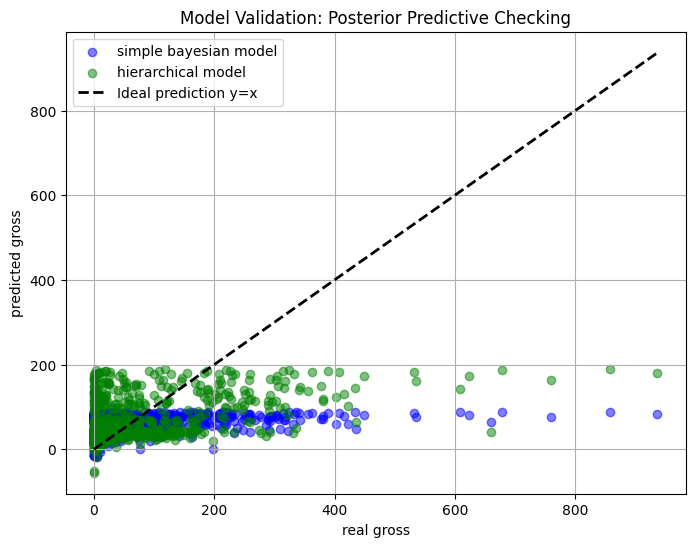

In [108]:
y_actual = data_simple['gross'].values

alpha_simple = fit_gross.stan_variable('alpha')
beta_simple = fit_gross.stan_variable('beta')
y_pred_simple = alpha_simple[:, None] + beta_simple[:, None] * \
    data_simple['year_scaled'].values
y_pred_simple_mean = y_pred_simple.mean(axis=0)

genre_indices = stan_data_gross_hier['genre'] - 1
alpha_samples = fit_gross_hier.stan_variable('alpha')
beta_samples = fit_gross_hier.stan_variable('beta')

y_pred_hierarchical = np.array([
    alpha_samples[:, genre] + beta_samples[:, genre] * year
    for genre, year in zip(genre_indices, \
                           data_simple['year_scaled'].values)
])
y_pred_hierarchical_mean = y_pred_hierarchical.mean(axis=1)
plt.figure(figsize=(8, 6))
plt.scatter(y_actual, y_pred_simple_mean, alpha=0.5, \
            label="simple bayesian model", color="blue")
plt.scatter(y_actual, y_pred_hierarchical_mean, alpha=0.5, \
            label="hierarchical model", color="green")
plt.plot([y_actual.min(), y_actual.max()], \
         [y_actual.min(), y_actual.max()], \
            'k--', lw=2, label="Ideal prediction y=x")

plt.title("Model Validation: Posterior Predictive Checking")
plt.xlabel("real gross")
plt.ylabel("predicted gross")
plt.legend()
plt.grid()
plt.show()

As can be seen from the figure, the hierarchical model is closer to y=x, \
which means it is closer to the real data distribution and the model prediction \
accuracy is higher. However, it still fails to capture the trend of gross maximum. \

In addition, the hierarchical model runs relatively slowly \
compared to the simple Bayesian model.